# Coursera ML Ex3 - Multi-classes Logistic Regression

## Introduction
In this exercise, we build an algorithm to solve a multi-classes classificication problem, that is to recognize handwritten digits images.  The features are each pixels in the image, and the target is one of the digits (0-9) that the image belongs to.  The one-vs-all technique is deployed to classify each of the classes in 10 iterations.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io
import scipy.optimize

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')


## Load Data

The file "ex3data1.mat" stores 5000 training examples in MATLAB format.  Each training example is a 20 pixel by 20 pixel grayscale image of the digit.  Each pixel is represented by a floating point number indicating the grayscale intensity at that location.  The 20 by 20 grid of pixels is "unrolled" into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.  To obtain a fair accuracy measurement, we split 20% of the examples, i.e. 1000, and have them reserved for testing.  The training process would only involve the remaining 80% dataset.

[ 2  4  9  2  4  8  9  3  5 10  2 10  9  4  3  1  2  4  3  2]


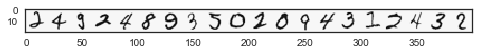

In [6]:
data = scipy.io.loadmat('./ex3data1.mat')
X = data['X']
y = data['y'].reshape(-1)
size = len(y)

# shuffle data
rindex = np.random.permutation(range(0,size))
X_train = X[rindex[:int(size*0.8)]]
y_train = y[rindex[:int(size*0.8)]]
X_test = X[rindex[int(size*0.8):]]
y_test = y[rindex[int(size*0.8):]]
m = len(y_train)

#display first 20 training data
print(y_train[:20])
plt.imshow(X_train[:20].reshape(-1,20).T)


## Cost Function

We have the logistic regression hypothesis function as follows

$${ h }_{ \theta  }(x)=g(\sum _{ j=0 }^{ n }{ { \theta  }_{ j }{ x }_{ j } } )\quad ,\quad { x }_{ 0 }=1$$

where the sigmoid function 

$$g(z)=\frac { 1 }{ 1+{ e }^{ -z } } $$

We define the cost function with regularization as

$$J(\theta )=\frac { 1 }{ m } \sum _{ i=1 }^{ m } \left[ -{ y }^{ (i) }log({ h }_{ \theta  }({ x }^{ (i) }))-(1-{ y }^{ (i) })log({ 1-h }_{ \theta  }({ x }^{ (i) })) \right] +\frac { \lambda  }{ 2m } \sum _{ j=1 }^{ n }{ { { \theta  }_{ j } }^{ 2 } } $$

We apply regularization as an objective to get a set of smaller $\theta$, meanwhile minimizing the cost function $J(\theta )$.  By having smaller $\theta$, the model could be more generalized to unseen data.  The degree of regularization is controlled by the parameter lambda $\lambda$.  By convention, regularization does not apply to ${ \theta  }_{ 0 }$.

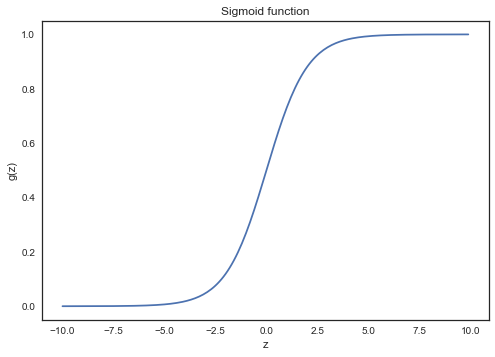

In [7]:
def sigmoid(z):
    g = 1. / (1. + np.exp(-z))
    return g

# plot sigmoid fnction
z = np.arange(-10,10,0.1)
g = sigmoid(z)
plt.plot(z,g)
plt.title('Sigmoid function')
plt.xlabel('z')
plt.ylabel('g(z)')

In [8]:
def computeCost(theta, X, y, _lambda):
    # hypothesis
    h = sigmoid(X.dot(theta))
    
    # theta for regularization
    theta_reg = theta
    theta_reg[0] = 0
    
    # cost
    J = 1./m * sum(-y*np.log(h)-(1.-y)*np.log(1.-h)) + _lambda/(2.*m)*sum(theta_reg**2)
    return J

## Gradient

By taking differentiation to the cost function $J(\theta )$, we have the gradient term for j=0:

$$\frac { \partial J(\theta ) }{ \partial { \theta  }_{ 0 } } =\frac { 1 }{ m } \sum _{ i=1 }^{ m } \left[ { (h }_{ \theta  }({ x }^{ (i) })-{ y }^{ (i) }){ \cdot { x }_{ 0 }^{ (i) } } \right]$$

and for j>0

$$\frac { \partial J(\theta ) }{ \partial { \theta  }_{ j } } =\frac { 1 }{ m } \sum _{ i=1 }^{ m } \left[ { (h }_{ \theta  }({ x }^{ (i) })-{ y }^{ (i) }){ \cdot { x }_{ j }^{ (i) } } \right] +\frac { \lambda  }{ m } { \theta  }_{ j }$$

In [9]:
def findGradient(theta, X, y, _lambda):
    # hypothesis
    h = sigmoid(X.dot(theta))
    
    # theta for regularization
    theta_reg = theta
    theta_reg[0] = 0
    
    # gradient
    grad = 1./m * X.T.dot(h-y) + float(_lambda/m) * theta_reg.T
    
    return grad

## Train One-vs-All Classes

We implement One-vs-all classification by training multiple regularized logistic regression classifiers, one for each of
the K classes in our dataset.  At the end, we will have all the classifier parameters in a K by (n+1) demension matrix $\Theta$, where each row of $\Theta$ corresponds to the learned logistic regression parameters for one class. 

Here, we use the adavanced gradient descent method called L-BFGS-B to acheive a greater performance for minimization.  We treat it as a block-box, but know that it would return the best estimation of $\theta$ with the minimum of $J(\theta )$.


In [10]:
def trianOneVsAll(k, X, y, _lambda):

    # 10 is used to representing 0 in the provided dataset
    if k==0: k=10
    
    # prepare design matrix
    X_design = np.c_[np.ones(m), X]

    # transform y from 1..10 to isK in (0,1)
    yk = (y==k)*1

    # no. of features (n)
    n = X.shape[1] + 1
    init_theta = np.zeros(n)
    
    # use the advanced gradient descent method L-BFGS-B provided in Scipy package
    Result = scipy.optimize.minimize(fun = computeCost, 
                     x0 = init_theta,
                     args = (X_design, yk, _lambda), 
                     method='L-BFGS-B',
                     jac = findGradient,
                     options=dict(maxiter=200, disp=True))
    theta = Result.x
    return theta

In [11]:
n = X_train.shape[1] + 1 # no. of features
K = 10 # no. of classes
_lambda = 0.1 # regularization parameter
Theta = np.zeros((K,n)) # Kxn matrix to store model parameters for each class

for k in range(0, K):
    theta_k = trianOneVsAll(k, X_train, y_train, _lambda)
    Theta[k] = theta_k

print(Theta.shape)

(10, 401)


## Predict Classes

After the one-vs-all classifier is trained, we predict the digit for a given image.  The one-vs-all prediction function picks the class for which the corresponding logistic regression classifier outputs the highest probability, and return the class label (1, 2,..., or K) as the prediction for the testing input example.  At the end, we will have the prediction accuracy among the testing set data be computed.


In [12]:
def predictClass(Theta, X):
    # prepare design matrix
    X_design = np.c_[np.ones(len(X)), X]

    # H is a mxK matrix to store hypothesis value for each instant in each class 
    H = sigmoid(X_design.dot(Theta.T)) 
    # the hypothesis class would be resulted by having the greatest H(k)
    p = np.argmax(H, axis=1)
    p[p==0] = 10 # use 10 to represent 0, align to input data
    return p

Target:
[9 7 9 3 8 7 6 5 1 1 7 9 3 5 6 1 8 4 1 9]
Prediction:
[ 9  7  9  3  2  7  6  5  1  1 10  9  3  5  6  1  8  4  1  9]


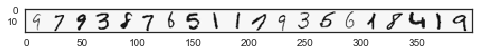

In [13]:
# shuffle the testing data
rindex = np.random.permutation(range(0,len(X_test)))
# display the first 20 input images and their labelled target
plt.imshow(X_test[rindex[:20]].reshape(-1,20).T)
print('Target:')
print(y_test[rindex[:20]])
# see if the predicted result matches
p = predictClass(Theta, X_test[rindex[:20]])
print('Prediction:')
print(p)

In [14]:
# output the prediction accuracy in %
p = predictClass(Theta, X_test)
accuracy = np.mean(p==y_test)*100
print('Testing set data accuracy: %.2f '%accuracy)

Testing set data accuracy: 90.10 
